### EECE5644 Assignment 2 - Question 1


#### Import necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#### Define problem parameters



In [4]:
prior_L0 = 0.6
prior_L1 = 0.4

# Mixture weights (equal for each class)
w01 = 0.5
w02 = 0.5
w11 = 0.5
w12 = 0.5

# Mean vectors for class L=0
m01 = np.array([-0.9, -1.1])
m02 = np.array([0.8, 0.75])

# Mean vectors for class L=1
m11 = np.array([-1.1, 0.9])
m12 = np.array([0.9, -0.75])

# Covariance matrix
C = np.array([[0.75, 0], [0, 1.25]])

print("Problem parameters defined:")
print(f"Class priors: P(L=0)={prior_L0}, P(L=1)={prior_L1}")
print(f"\nMeans for L=0:\n  m01={m01}\n  m02={m02}")
print(f"\nMeans for L=1:\n  m11={m11}\n  m12={m12}")
print(f"\nCovariance matrix (all components):\n{C}")

Problem parameters defined:
Class priors: P(L=0)=0.6, P(L=1)=0.4

Means for L=0:
  m01=[-0.9 -1.1]
  m02=[0.8  0.75]

Means for L=1:
  m11=[-1.1  0.9]
  m12=[ 0.9  -0.75]

Covariance matrix (all components):
[[0.75 0.  ]
 [0.   1.25]]


#### Define function to generate data from the GMM

In [5]:
def generate_data(n_samples, prior_L0, prior_L1, 
                 m01, m02, m11, m12, C, 
                 w01=0.5, w02=0.5, w11=0.5, w12=0.5):
    X = []
    labels = []
    
    for _ in range(n_samples):
        label = np.random.choice([0, 1], p=[prior_L0, prior_L1])
        
        if label == 0:
            # Sample from class 0 mixture
            component = np.random.choice([0, 1], p=[w01, w02])
            if component == 0:
                sample = np.random.multivariate_normal(m01, C)
            else:
                sample = np.random.multivariate_normal(m02, C)
        else:
            # Sample from class 1 mixture
            component = np.random.choice([0, 1], p=[w11, w12])
            if component == 0:
                sample = np.random.multivariate_normal(m11, C)
            else:
                sample = np.random.multivariate_normal(m12, C)
        
        X.append(sample)
        labels.append(label)
    
    return np.array(X), np.array(labels)

#### Generate all required datasets

In [6]:


# Training
X_train_50, y_train_50 = generate_data(50, prior_L0, prior_L1, m01, m02, m11, m12, C)
X_train_500, y_train_500 = generate_data(500, prior_L0, prior_L1, m01, m02, m11, m12, C)
X_train_5000, y_train_5000 = generate_data(5000, prior_L0, prior_L1, m01, m02, m11, m12, C)

# Validation
X_validate, y_validate = generate_data(10000, prior_L0, prior_L1, m01, m02, m11, m12, C)

print("Datasets generated:")
print(f"D_train_50: {X_train_50.shape[0]} samples")
print(f"D_train_500: {X_train_500.shape[0]} samples")
print(f"D_train_5000: {X_train_5000.shape[0]} samples")
print(f"D_validate: {X_validate.shape[0]} samples")

print(f"\nValidation set class distribution:")
print(f"  Class 0: {np.sum(y_validate == 0)} ({np.mean(y_validate == 0):.3f})")
print(f"  Class 1: {np.sum(y_validate == 1)} ({np.mean(y_validate == 1):.3f})")

Datasets generated:
D_train_50: 50 samples
D_train_500: 500 samples
D_train_5000: 5000 samples
D_validate: 10000 samples

Validation set class distribution:
  Class 0: 5940 (0.594)
  Class 1: 4060 (0.406)


#### Visualize the generated data



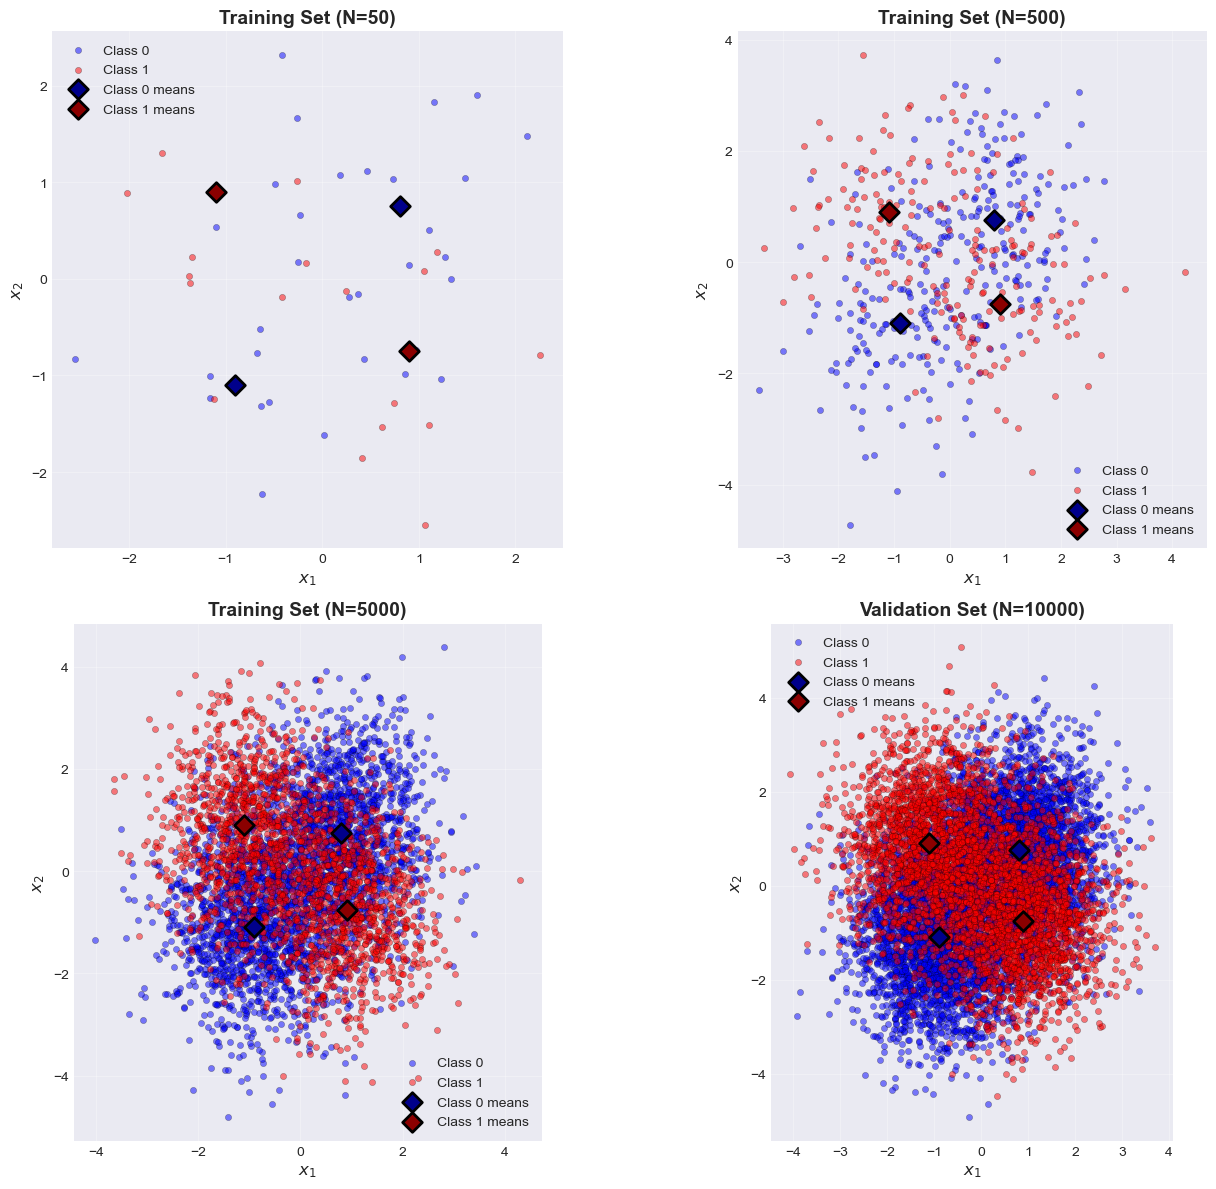

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

datasets = [
    (X_train_50, y_train_50, 'Training Set (N=50)'),
    (X_train_500, y_train_500, 'Training Set (N=500)'),
    (X_train_5000, y_train_5000, 'Training Set (N=5000)'),
    (X_validate, y_validate, 'Validation Set (N=10000)')
]

for idx, (X, y, title) in enumerate(datasets):
    ax = axes[idx // 2, idx % 2]
    
    # Plot class 0
    X_class0 = X[y == 0]
    ax.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', alpha=0.5, 
               label='Class 0', s=20, edgecolors='k', linewidth=0.3)
    
    # Plot class 1
    X_class1 = X[y == 1]
    ax.scatter(X_class1[:, 0], X_class1[:, 1], c='red', alpha=0.5, 
               label='Class 1', s=20, edgecolors='k', linewidth=0.3)
    
    # Plot means
    ax.scatter([m01[0], m02[0]], [m01[1], m02[1]], c='darkblue', 
               marker='D', s=100, edgecolors='black', linewidth=2, 
               label='Class 0 means', zorder=5)
    ax.scatter([m11[0], m12[0]], [m11[1], m12[1]], c='darkred', 
               marker='D', s=100, edgecolors='black', linewidth=2, 
               label='Class 1 means', zorder=5)
    
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### Part 1
#### Implement class-conditional likelihood functions

In [11]:
def class_conditional_pdf(x, label, m01, m02, m11, m12, C, w01=0.5, w02=0.5, w11=0.5, w12=0.5):
    # Ensure x is 2D
    if x.ndim == 1:
        x = x.reshape(1, -1)
        squeeze = True
    else:
        squeeze = False
    
    if label == 0:
        pdf1 = multivariate_normal.pdf(x, mean=m01, cov=C)
        pdf2 = multivariate_normal.pdf(x, mean=m02, cov=C)
        likelihood = w01 * pdf1 + w02 * pdf2
    else:
        pdf1 = multivariate_normal.pdf(x, mean=m11, cov=C)
        pdf2 = multivariate_normal.pdf(x, mean=m12, cov=C)
        likelihood = w11 * pdf1 + w12 * pdf2
    
    if squeeze:
        likelihood = likelihood[0]
    
    return likelihood

#### Implement optimal Bayes classifier



In [12]:
def optimal_classifier(X, prior_L0, prior_L1, m01, m02, m11, m12, C):
    p_x_given_L0 = class_conditional_pdf(X, 0, m01, m02, m11, m12, C)
    p_x_given_L1 = class_conditional_pdf(X, 1, m01, m02, m11, m12, C)
    
    log_likelihood_ratio = (np.log(p_x_given_L1 + 1e-300) + np.log(prior_L1) - 
                           np.log(p_x_given_L0 + 1e-300) - np.log(prior_L0))
    
    predictions = (log_likelihood_ratio > 0).astype(int)
    
    return predictions, log_likelihood_ratio


#### Apply optimal classifier to validation set



In [13]:
# Predictions and discriminant scores
y_pred_optimal, discriminant_scores = optimal_classifier(
    X_validate, prior_L0, prior_L1, m01, m02, m11, m12, C
)

# Calculate confusion matrix
cm_optimal = confusion_matrix(y_validate, y_pred_optimal)

# Calculate probability of error
error_rate_optimal = 1 - np.mean(y_pred_optimal == y_validate)

print("Optimal Classifier Performance on Validation Set:")
print(f"\nProbability of Error: {error_rate_optimal:.4f}")
print(f"Accuracy: {1 - error_rate_optimal:.4f}")
print(f"\nConfusion Matrix:")
print(cm_optimal)
print(f"\nTrue Negatives: {cm_optimal[0, 0]}")
print(f"False Positives: {cm_optimal[0, 1]}")
print(f"False Negatives: {cm_optimal[1, 0]}")
print(f"True Positives: {cm_optimal[1, 1]}")

Optimal Classifier Performance on Validation Set:

Probability of Error: 0.2807
Accuracy: 0.7193

Confusion Matrix:
[[5017  923]
 [1884 2176]]

True Negatives: 5017
False Positives: 923
False Negatives: 1884
True Positives: 2176


#### Compute and plot ROC curve

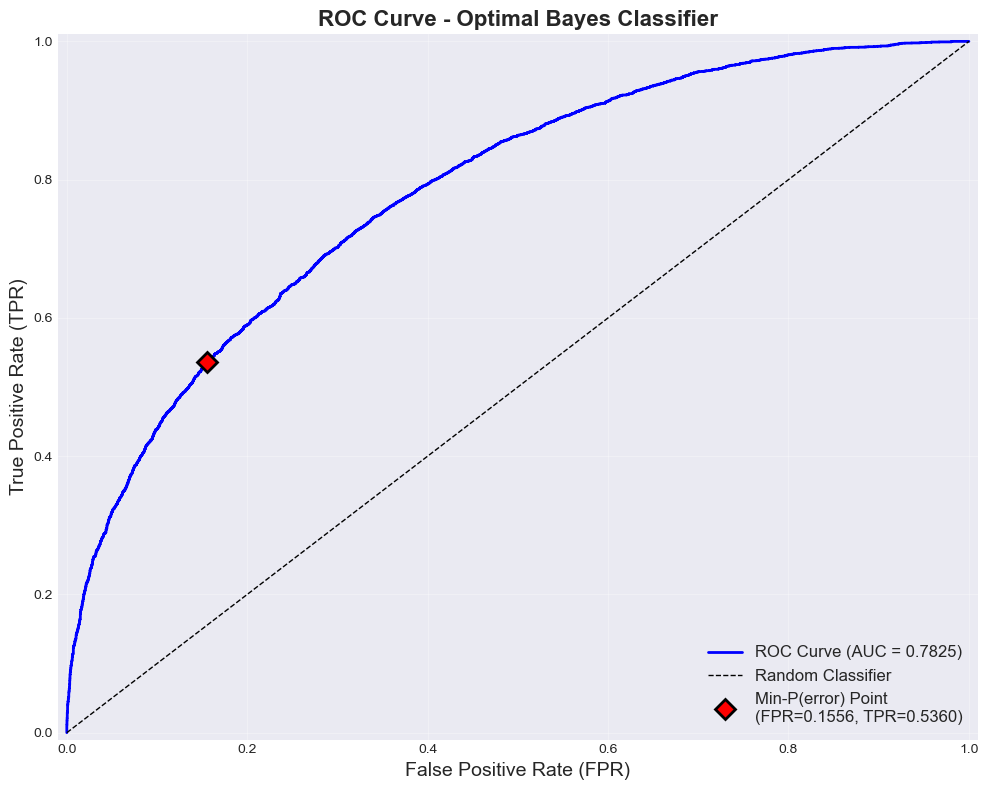


ROC Analysis:
AUC: 0.7825
Min-P(error) operating point: FPR=0.1556, TPR=0.5360
Estimated min-P(error): 0.2807


In [16]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_validate, discriminant_scores)
roc_auc = auc(fpr, tpr)

# Find the point on ROC corresponding to threshold = 0 (min P(error) classifier)
# This is where we make the decision
optimal_threshold_idx = np.argmin(np.abs(thresholds - 0))
optimal_fpr = fpr[optimal_threshold_idx]
optimal_tpr = tpr[optimal_threshold_idx]

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.plot(optimal_fpr, optimal_tpr, 'rD', markersize=10, 
         label=f'Min-P(error) Point\n(FPR={optimal_fpr:.4f}, TPR={optimal_tpr:.4f})',
         markeredgecolor='black', markeredgewidth=2)

plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve - Optimal Bayes Classifier', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.tight_layout()
plt.show()

print(f"\nROC Analysis:")
print(f"AUC: {roc_auc:.4f}")
print(f"Min-P(error) operating point: FPR={optimal_fpr:.4f}, TPR={optimal_tpr:.4f}")
print(f"Estimated min-P(error): {error_rate_optimal:.4f}")

#### Visualize decision boundary



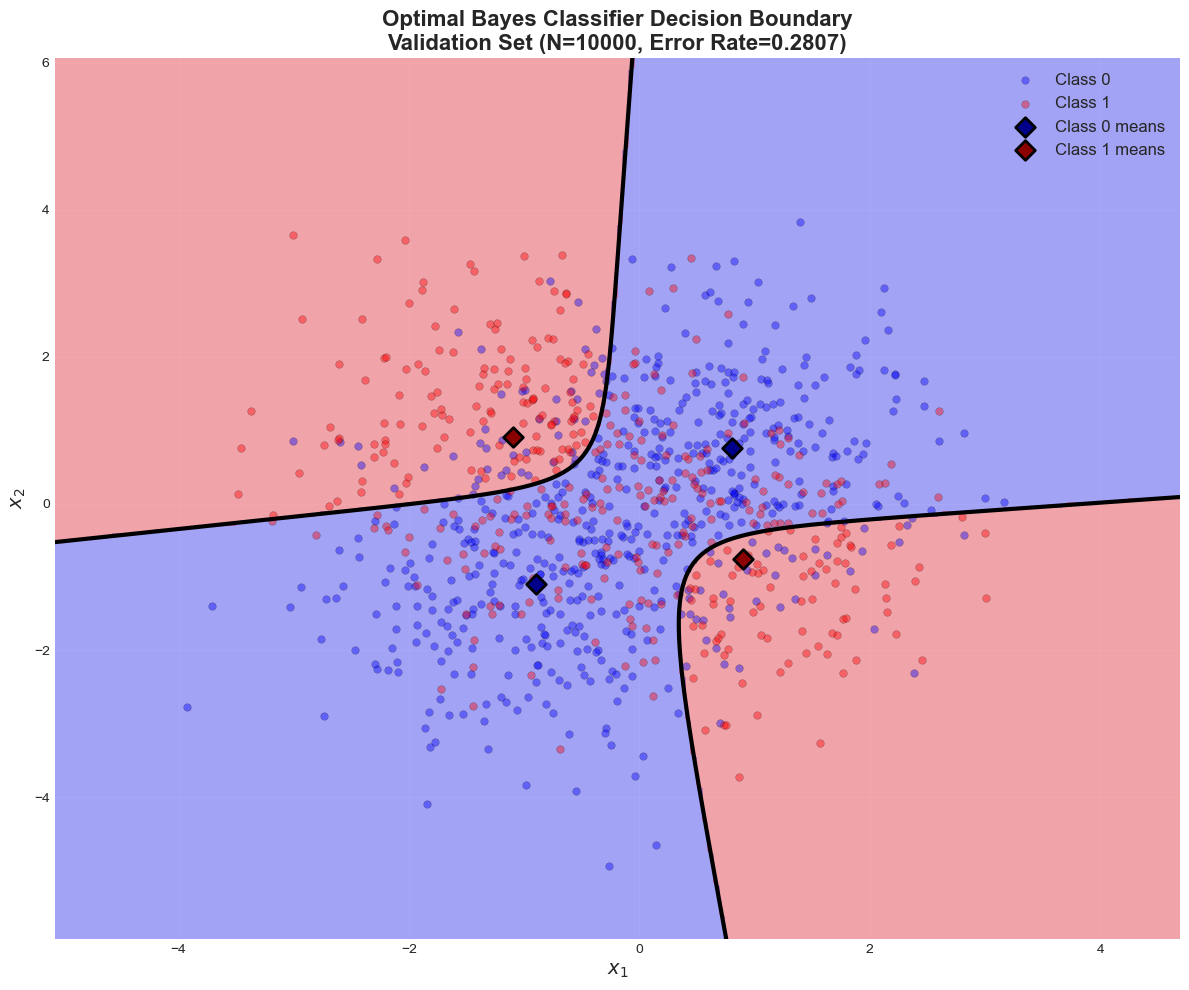

In [18]:
# Create a grid of points
x1_min, x1_max = X_validate[:, 0].min() - 1, X_validate[:, 0].max() + 1
x2_min, x2_max = X_validate[:, 1].min() - 1, X_validate[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                        np.linspace(x2_min, x2_max, 200))

# Flatten the grid
grid_points = np.c_[xx1.ravel(), xx2.ravel()]

# Get predictions for grid points
grid_predictions, grid_scores = optimal_classifier(
    grid_points, prior_L0, prior_L1, m01, m02, m11, m12, C
)

# Reshape predictions
grid_predictions = grid_predictions.reshape(xx1.shape)
grid_scores = grid_scores.reshape(xx1.shape)

# Plot decision boundary
plt.figure(figsize=(12, 10))

# Plot decision regions
plt.contourf(xx1, xx2, grid_predictions, levels=1, alpha=0.3, colors=['blue', 'red'])

# Plot decision boundary (where discriminant score = 0)
plt.contour(xx1, xx2, grid_scores, levels=[0], colors='black', linewidths=3)

# Plot validation samples (subsample for clarity)
sample_indices = np.random.choice(len(X_validate), size=1000, replace=False)
X_sample = X_validate[sample_indices]
y_sample = y_validate[sample_indices]

plt.scatter(X_sample[y_sample == 0, 0], X_sample[y_sample == 0, 1], 
           c='blue', alpha=0.4, s=30, edgecolors='k', linewidth=0.3, label='Class 0')
plt.scatter(X_sample[y_sample == 1, 0], X_sample[y_sample == 1, 1], 
           c='red', alpha=0.4, s=30, edgecolors='k', linewidth=0.3, label='Class 1')

# Plot means
plt.scatter([m01[0], m02[0]], [m01[1], m02[1]], c='darkblue', 
           marker='D', s=100, edgecolors='black', linewidth=2, 
           label='Class 0 means', zorder=5)
plt.scatter([m11[0], m12[0]], [m11[1], m12[1]], c='darkred', 
           marker='D', s=100, edgecolors='black', linewidth=2, 
           label='Class 1 means', zorder=5)

plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Optimal Bayes Classifier Decision Boundary\n' + 
         f'Validation Set (N=10000, Error Rate={error_rate_optimal:.4f})', 
         fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Part 2: Logistic Regression Classifiers

#### Part 2a: Logistic-Linear Function
#### Define logistic regression functions



In [ ]:
def logistic_linear_features(X):
    n_samples = X.shape[0]
    Z = np.column_stack([np.ones(n_samples), X])
    return Z

def logistic_quadratic_features(X):
    n_samples = X.shape[0]
    x1 = X[:, 0]
    x2 = X[:, 1]
    Z = np.column_stack([np.ones(n_samples), x1, x2, x1**2, x1*x2, x2**2])
    return Z

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def negative_log_likelihood(w, Z, y):
    h = sigmoid(Z @ w)
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    nll = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return nll

def train_logistic_regression(X, y, feature_func, method='BFGS'):
    Z = feature_func(X)
    n_features = Z.shape[1]
    
    # Initialize weights
    w_init = np.zeros(n_features)
    
    # Optimize
    result = minimize(negative_log_likelihood, w_init, args=(Z, y), 
                     method=method, options={'maxiter': 1000})
    
    return result.x

def predict_logistic(X, w, feature_func, threshold=0.5):
    Z = feature_func(X)
    probabilities = sigmoid(Z @ w)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

#### Train logistic-linear models on different training set sizes



In [20]:
# Train on 50 samples
print("Training on 50 samples...")
w_linear_50 = train_logistic_regression(X_train_50, y_train_50, logistic_linear_features)
y_pred_linear_50, _ = predict_logistic(X_validate, w_linear_50, logistic_linear_features)
error_linear_50 = 1 - np.mean(y_pred_linear_50 == y_validate)
print(f"  Trained weights: {w_linear_50}")
print(f"  Validation error: {error_linear_50:.4f}\n")

# Train on 500 samples
print("Training on 500 samples...")
w_linear_500 = train_logistic_regression(X_train_500, y_train_500, logistic_linear_features)
y_pred_linear_500, _ = predict_logistic(X_validate, w_linear_500, logistic_linear_features)
error_linear_500 = 1 - np.mean(y_pred_linear_500 == y_validate)
print(f"  Trained weights: {w_linear_500}")
print(f"  Validation error: {error_linear_500:.4f}\n")

# Train on 5000 samples
print("Training on 5000 samples...")
w_linear_5000 = train_logistic_regression(X_train_5000, y_train_5000, logistic_linear_features)
y_pred_linear_5000, _ = predict_logistic(X_validate, w_linear_5000, logistic_linear_features)
error_linear_5000 = 1 - np.mean(y_pred_linear_5000 == y_validate)
print(f"  Trained weights: {w_linear_5000}")
print(f"  Validation error: {error_linear_5000:.4f}\n")

# Summary
print("="*60)
print("Logistic-Linear Model Summary")
print("="*60)
print(f"Training Set Size | Validation Error")
print(f"-"*60)
print(f"      50          |     {error_linear_50:.4f}")
print(f"     500          |     {error_linear_500:.4f}")
print(f"    5000          |     {error_linear_5000:.4f}")
print(f"-"*60)
print(f"Optimal (Bayes)  |     {error_rate_optimal:.4f}")
print("="*60)

Training on 50 samples...
  Trained weights: [-0.62748548 -0.19645413 -0.3674718 ]
  Validation error: 0.5151

Training on 500 samples...
  Trained weights: [-0.34950341 -0.02648112  0.10767142]
  Validation error: 0.4003

Training on 5000 samples...
  Trained weights: [-0.41269963 -0.03027525  0.1033109 ]
  Validation error: 0.4047

Logistic-Linear Model Summary
Training Set Size | Validation Error
------------------------------------------------------------
      50          |     0.5151
     500          |     0.4003
    5000          |     0.4047
------------------------------------------------------------
Optimal (Bayes)  |     0.2807


### Part 2b: Logistic-Quadratic Function
#### Train logistic-quadratic models on different training set sizes

In [21]:
print("Training Logistic-Quadratic Models...\n")

# Train on 50 samples
print("Training on 50 samples...")
w_quad_50 = train_logistic_regression(X_train_50, y_train_50, logistic_quadratic_features)
y_pred_quad_50, _ = predict_logistic(X_validate, w_quad_50, logistic_quadratic_features)
error_quad_50 = 1 - np.mean(y_pred_quad_50 == y_validate)
print(f"  Trained weights: {w_quad_50}")
print(f"  Validation error: {error_quad_50:.4f}\n")

# Train on 500 samples
print("Training on 500 samples...")
w_quad_500 = train_logistic_regression(X_train_500, y_train_500, logistic_quadratic_features)
y_pred_quad_500, _ = predict_logistic(X_validate, w_quad_500, logistic_quadratic_features)
error_quad_500 = 1 - np.mean(y_pred_quad_500 == y_validate)
print(f"  Trained weights: {w_quad_500}")
print(f"  Validation error: {error_quad_500:.4f}\n")

# Train on 5000 samples
print("Training on 5000 samples...")
w_quad_5000 = train_logistic_regression(X_train_5000, y_train_5000, logistic_quadratic_features)
y_pred_quad_5000, _ = predict_logistic(X_validate, w_quad_5000, logistic_quadratic_features)
error_quad_5000 = 1 - np.mean(y_pred_quad_5000 == y_validate)
print(f"  Trained weights: {w_quad_5000}")
print(f"  Validation error: {error_quad_5000:.4f}\n")

# Summary
print("="*60)
print("Logistic-Quadratic Model Summary")
print("="*60)
print(f"Training Set Size | Validation Error")
print(f"-"*60)
print(f"      50          |     {error_quad_50:.4f}")
print(f"     500          |     {error_quad_500:.4f}")
print(f"    5000          |     {error_quad_5000:.4f}")
print(f"-"*60)
print(f"Optimal (Bayes)  |     {error_rate_optimal:.4f}")
print("="*60)

Training Logistic-Quadratic Models...

Training on 50 samples...
  Trained weights: [-0.70732216 -0.59819732 -0.53155945  0.20450765 -1.51748872 -0.34284559]
  Validation error: 0.2988

Training on 500 samples...
  Trained weights: [-0.44002712 -0.02635008  0.13019288  0.1278091  -0.90566371 -0.01797699]
  Validation error: 0.2857

Training on 5000 samples...
  Trained weights: [-0.4951111  -0.0644539   0.06606189  0.07679907 -0.82241018 -0.03139762]
  Validation error: 0.2855

Logistic-Quadratic Model Summary
Training Set Size | Validation Error
------------------------------------------------------------
      50          |     0.2988
     500          |     0.2857
    5000          |     0.2855
------------------------------------------------------------
Optimal (Bayes)  |     0.2807


#### Visualize decision boundaries for logistic-linear models



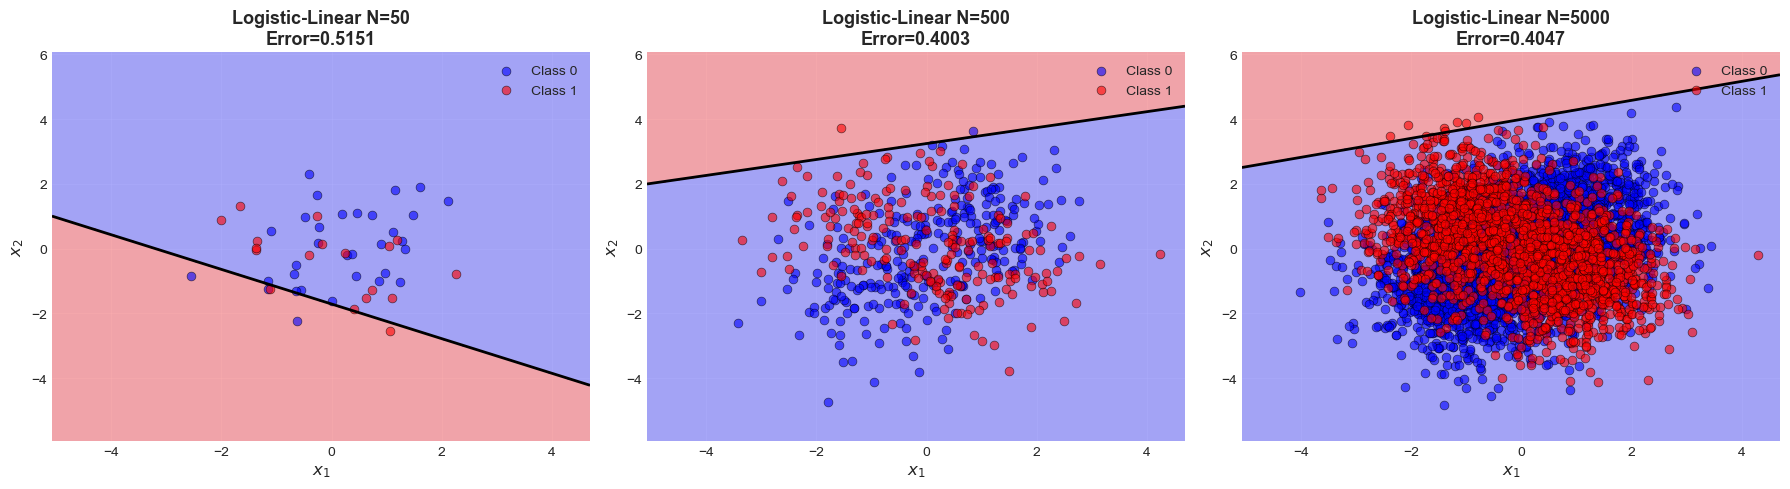

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    (w_linear_50, X_train_50, y_train_50, 'N=50', error_linear_50),
    (w_linear_500, X_train_500, y_train_500, 'N=500', error_linear_500),
    (w_linear_5000, X_train_5000, y_train_5000, 'N=5000', error_linear_5000)
]

for idx, (w, X_train, y_train, title, error) in enumerate(models):
    ax = axes[idx]
    
    # Create grid
    x1_min, x1_max = X_validate[:, 0].min() - 1, X_validate[:, 0].max() + 1
    x2_min, x2_max = X_validate[:, 1].min() - 1, X_validate[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    
    # Get predictions
    grid_pred, grid_prob = predict_logistic(grid_points, w, logistic_linear_features)
    grid_pred = grid_pred.reshape(xx1.shape)
    grid_prob = grid_prob.reshape(xx1.shape)
    
    # Plot decision regions
    ax.contourf(xx1, xx2, grid_pred, levels=1, alpha=0.3, colors=['blue', 'red'])
    
    # Plot decision boundary
    ax.contour(xx1, xx2, grid_prob, levels=[0.5], colors='black', linewidths=2)
    
    # Plot training samples
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
              c='blue', alpha=0.6, s=40, edgecolors='k', linewidth=0.5, label='Class 0')
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
              c='red', alpha=0.6, s=40, edgecolors='k', linewidth=0.5, label='Class 1')
    
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title(f'Logistic-Linear {title}\nError={error:.4f}', 
                fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([x1_min, x1_max])
    ax.set_ylim([x2_min, x2_max])

plt.tight_layout()
plt.show()


#### Visualize decision boundaries for logistic-quadratic models

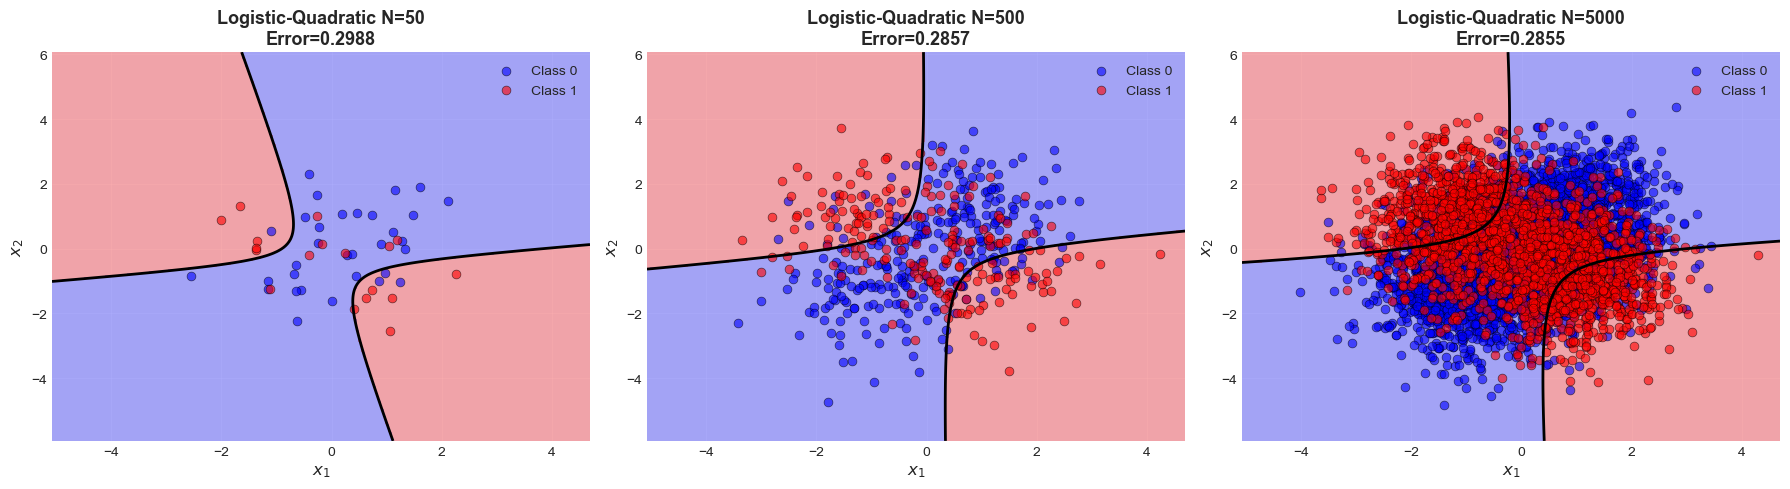

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = [
    (w_quad_50, X_train_50, y_train_50, 'N=50', error_quad_50),
    (w_quad_500, X_train_500, y_train_500, 'N=500', error_quad_500),
    (w_quad_5000, X_train_5000, y_train_5000, 'N=5000', error_quad_5000)
]

for idx, (w, X_train, y_train, title, error) in enumerate(models):
    ax = axes[idx]
    
    # Create grid
    x1_min, x1_max = X_validate[:, 0].min() - 1, X_validate[:, 0].max() + 1
    x2_min, x2_max = X_validate[:, 1].min() - 1, X_validate[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    
    # Get predictions
    grid_pred, grid_prob = predict_logistic(grid_points, w, logistic_quadratic_features)
    grid_pred = grid_pred.reshape(xx1.shape)
    grid_prob = grid_prob.reshape(xx1.shape)
    
    # Plot decision regions
    ax.contourf(xx1, xx2, grid_pred, levels=1, alpha=0.3, colors=['blue', 'red'])
    
    # Plot decision boundary
    ax.contour(xx1, xx2, grid_prob, levels=[0.5], colors='black', linewidths=2)
    
    # Plot training samples
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
              c='blue', alpha=0.6, s=40, edgecolors='k', linewidth=0.5, label='Class 0')
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
              c='red', alpha=0.6, s=40, edgecolors='k', linewidth=0.5, label='Class 1')
    
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title(f'Logistic-Quadratic {title}\nError={error:.4f}', 
                fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([x1_min, x1_max])
    ax.set_ylim([x2_min, x2_max])

plt.tight_layout()
plt.show()

#### Comprehensive comparison of all models


COMPREHENSIVE MODEL COMPARISON
             Model  Error Rate  Accuracy
     Optimal Bayes      0.2807    0.7193
     Linear (N=50)      0.5151    0.4849
    Linear (N=500)      0.4003    0.5997
   Linear (N=5000)      0.4047    0.5953
  Quadratic (N=50)      0.2988    0.7012
 Quadratic (N=500)      0.2857    0.7143
Quadratic (N=5000)      0.2855    0.7145


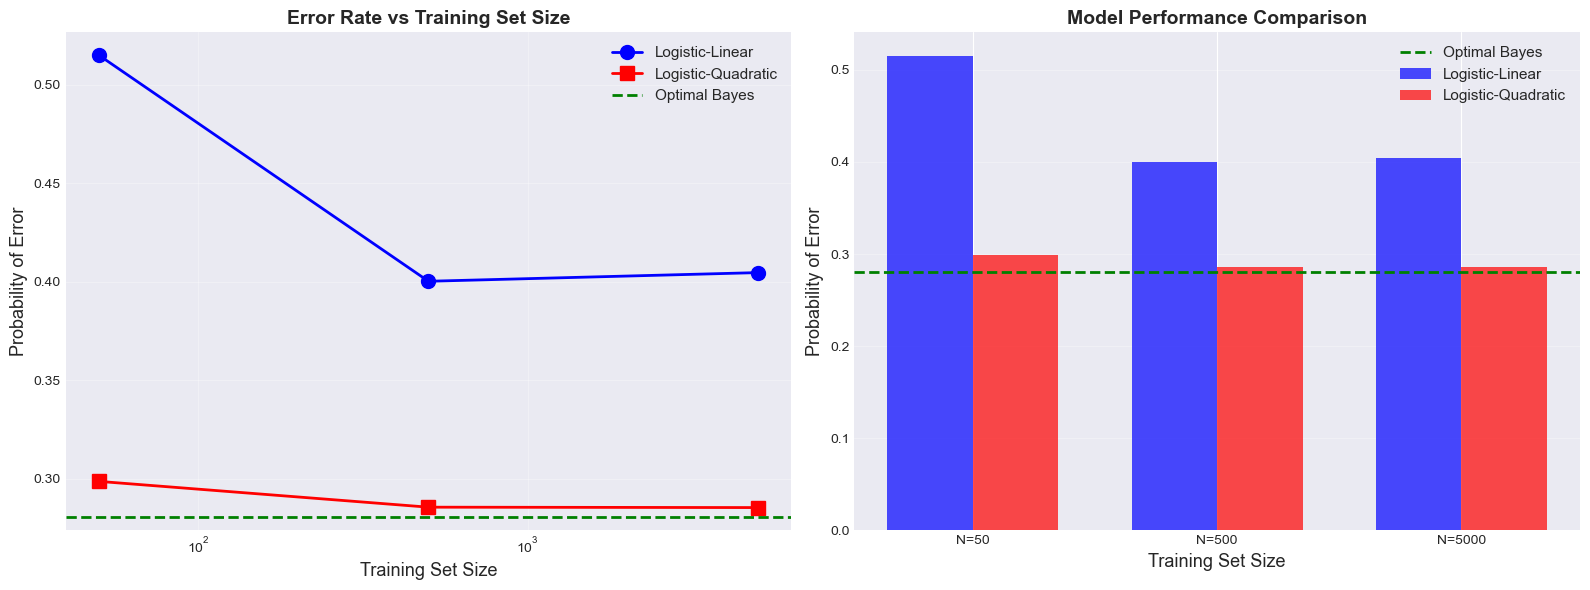

In [26]:
results = {
    'Model': ['Optimal Bayes', 'Linear (N=50)', 'Linear (N=500)', 'Linear (N=5000)',
             'Quadratic (N=50)', 'Quadratic (N=500)', 'Quadratic (N=5000)'],
    'Error Rate': [error_rate_optimal, error_linear_50, error_linear_500, error_linear_5000,
                  error_quad_50, error_quad_500, error_quad_5000],
    'Accuracy': [1-error_rate_optimal, 1-error_linear_50, 1-error_linear_500, 1-error_linear_5000,
                1-error_quad_50, 1-error_quad_500, 1-error_quad_5000]
}

import pandas as pd
df_results = pd.DataFrame(results)
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)
print(df_results.to_string(index=False))
print("="*70)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error rate comparison
training_sizes = [50, 500, 5000]
linear_errors = [error_linear_50, error_linear_500, error_linear_5000]
quad_errors = [error_quad_50, error_quad_500, error_quad_5000]

axes[0].plot(training_sizes, linear_errors, 'o-', linewidth=2, markersize=10, 
            label='Logistic-Linear', color='blue')
axes[0].plot(training_sizes, quad_errors, 's-', linewidth=2, markersize=10, 
            label='Logistic-Quadratic', color='red')
axes[0].axhline(y=error_rate_optimal, color='green', linestyle='--', linewidth=2, 
               label='Optimal Bayes')
axes[0].set_xlabel('Training Set Size', fontsize=13)
axes[0].set_ylabel('Probability of Error', fontsize=13)
axes[0].set_title('Error Rate vs Training Set Size', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Bar chart comparison
x = np.arange(len(training_sizes))
width = 0.35

axes[1].bar(x - width/2, linear_errors, width, label='Logistic-Linear', color='blue', alpha=0.7)
axes[1].bar(x + width/2, quad_errors, width, label='Logistic-Quadratic', color='red', alpha=0.7)
axes[1].axhline(y=error_rate_optimal, color='green', linestyle='--', linewidth=2, 
               label='Optimal Bayes')

axes[1].set_xlabel('Training Set Size', fontsize=13)
axes[1].set_ylabel('Probability of Error', fontsize=13)
axes[1].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['N=50', 'N=500', 'N=5000'])
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

